In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon
import pickle 
import cv2 as cv

from src.vican.vican.cam import estimate_pose_mp, estimate_pose_charuco_worker
from src.vican.vican.bipgo import bipartite_se3sync, object_bipartite_se3sync
from src.vican.vican.plot import plot2D, plot_cams_3D
from src.vican.vican.dataset import Dataset

# Edit path to the folder containing the renders
DATASET_PATH = "./dataset/optitrack_videos/output_frames"
#DATASET_PATH= "./dataset/big_dataset"

# Edit path to the folder containing the cube calibration images.
#OBJ_DATASET_PATH = "./dataset/optitrack_videos/output_object"
OBJ_DATASET_PATH = "./dataset/realsense_charuco_object"

LOAD = False

dataset     = Dataset(root=DATASET_PATH)
obj_dataset = Dataset(root=OBJ_DATASET_PATH)

# TODO: why??


len(dataset.im_data["filename"])

8000

# Use below to rename object calib files (if needed) !!

In [2]:
import os
from PIL import Image
import os

# fix object image names

folders = os.listdir(OBJ_DATASET_PATH)
for folder in folders:
    if os.path.isdir(os.path.join(OBJ_DATASET_PATH, folder)):
        file = os.listdir(os.path.join(OBJ_DATASET_PATH, folder))[0].split('.')[0]
        if file != folder:
            os.rename(os.path.join(OBJ_DATASET_PATH, folder, file + ".png"), os.path.join(OBJ_DATASET_PATH, folder, folder + ".jpg"))
        #print(folder, file)
    
    
"""
# Define the function to convert PNG to JPG
for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        if file.endswith(".png"):
            png_path = os.path.join(root, file)
            jpg_path = os.path.splitext(png_path)[0] + ".jpg"
            os.rename(png_path, jpg_path) """



'\n# Define the function to convert PNG to JPG\nfor root, dirs, files in os.walk(DATASET_PATH):\n    for file in files:\n        if file.endswith(".png"):\n            png_path = os.path.join(root, file)\n            jpg_path = os.path.splitext(png_path)[0] + ".jpg"\n            os.rename(png_path, jpg_path) '

# CharucoBoards Definitions

In [3]:
from src.vican.vican.cam import estimate_pose_charuco_worker

charuco_dict = dict()

board_idx = 0
for i in [np.arange(6), np.arange(4) + 6 ,  np.arange(6)+ 12, np.arange(4)+18]:
    
    if len(i) == 6:
        sz = (4,3)
    else:
        sz = (3,3)
    
    charuco_dict[str(board_idx)] = dict()
    charuco_dict[str(board_idx)]["sizeX"] = sz[0]
    charuco_dict[str(board_idx)]["sizeY"] = sz[1]
    charuco_dict[str(board_idx)]["squareLength"] = 0.130
    charuco_dict[str(board_idx)]["markerLength"] = 0.097
    charuco_dict[str(board_idx)]["dictionary"] = cv.aruco.DICT_4X4_100
    charuco_dict[str(board_idx)]["ids"] = i
    board_idx += 1
    
charuco_dict["detector"] = estimate_pose_charuco_worker
charuco_dict["num_boards"] = board_idx - 1


# Arucos Definition

In [4]:
from src.vican.vican.cam import estimate_pose_aruco_worker

aruco_obj = dict()
#aruco_obj["dictionary"] = 'DICT_ARUCO_ORIGINAL'
aruco_obj["dictionary"] = 'DICT_4X4_100'
aruco_obj["marker_size"] = 0.097

#aruco_obj["marker_ids"] = ['10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9']
aruco_obj["marker_ids"] = [str(i) for i in range(0, 21)]
aruco_obj["corner_refine"] = 'CORNER_REFINE_SUBPIX'
aruco_obj["detector"] = estimate_pose_aruco_worker

# Verify OpenCV detection

[[ 0.03893044]
 [-0.07114776]
 [ 0.05850143]]
[[0.12172753]
 [0.07931892]
 [0.30485152]]


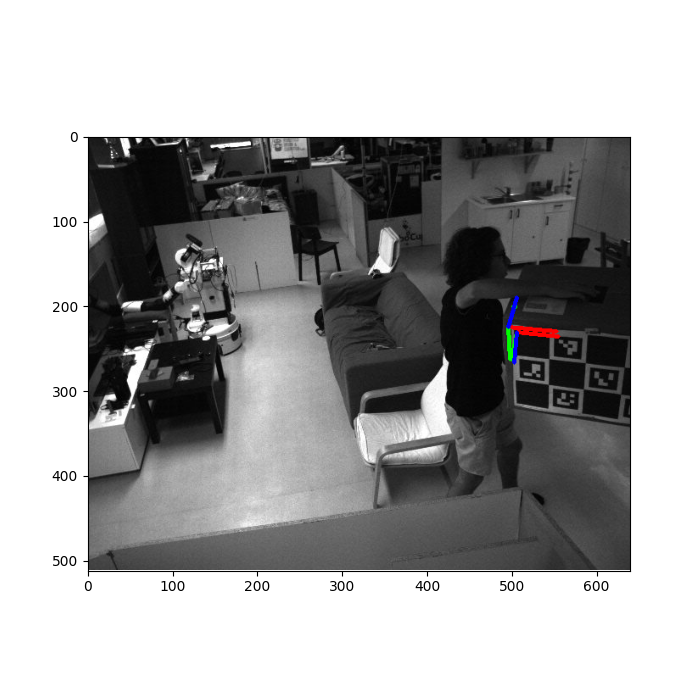

In [6]:
import cv2 as cv
from src.vican.vican.plot import detect_and_draw_charuco, detect_and_draw_aruco

%matplotlib widget

plt.figure(figsize=(7,7))





cam_id = "9"
time = "219"

idx = np.random.randint(0, len(dataset.im_data["filename"]))

for i in range(0, len(dataset.im_data["filename"])):
    if dataset.im_data["cam_id"][i] == cam_id and dataset.im_data["timestamp"][i] == time:
        idx = i
    
if 1:
    im = detect_and_draw_charuco(dataset.im_data["filename"][idx],
                                dataset.cams[cam_id],
                                charuco_dict,
                                test= np.array([[-np.pi/4],[np.pi/4],[-np.pi/2]]) )
    
else:
    im = detect_and_draw_aruco(dataset.im_data["filename"][idx],
                                'DICT_4X4_100',
                                dataset.cams[cam_id],
                                0,
                                0)

im = cv.cvtColor(im, cv.COLOR_BGR2RGB)

plt.imshow(im)

# Calibrate object

In [6]:
if not LOAD:
    # This will compute camera-marker edges via PnP, in parallel
    aux = estimate_pose_mp(cams=obj_dataset.im_data['cam'],
                           im_filenames=obj_dataset.im_data['filename'],
                           #target_dict = aruco_obj,
                           #flags='SOLVEPNP_IPPE_SQUARE',
                           target_dict = charuco_dict,
                           flags='SOLVEPNP_IPPE',
                           brightness=0,
                           contrast=0)
    
    pickle.dump(aux, open(os.path.join(OBJ_DATASET_PATH, 'cube_calib_pose.pkl'), 'wb'))
    print("Saved")
else:
    aux = pickle.load(open(os.path.join(OBJ_DATASET_PATH, 'cube_calib_pose.pkl'), 'rb'))
    print("Loaded")


Marker detection
Received 26 images.
Started pool of 8 workers.
Merging dictionaries...
Found markers in 26 images
Finished: 48 markers detected.
Saved


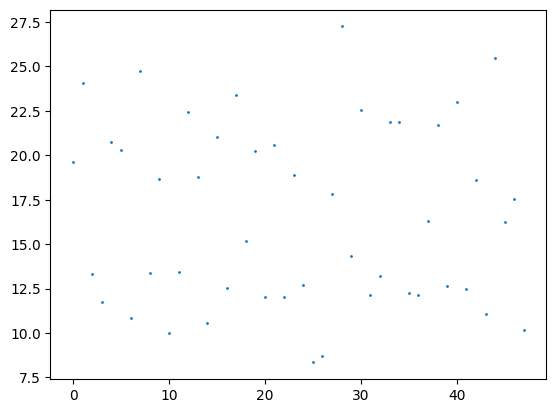

In [32]:
plt.figure()
data = np.array(  [ [edge["other_error"], edge["reprojected_err"]] for edge in aux.values() ] )

plt.plot(data[:,0]  - data[:,1], ".", markersize=2)
plt.show()

In [8]:
# Optimization - see extended paper

obj_pose_est = object_bipartite_se3sync(aux,
                                        noise_model_r=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1,
                                        noise_model_t=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1,
                                        edge_filter=lambda edge : edge['reprojected_err'] < 1.5,
                                        maxiter=4,
                                        lsqr_solver="conjugate_gradient",
                                        dtype=np.float64)


Received graph with 30 nodes 48 edges
Applying constraints (0.005s).
Bipartite graph: 4 cameras, 26 timesteps, 48 edges.
Building 4x26 adjacency and 12x78 SO(3) sparse matrices (0.000s).
Building power graph (0.002s).


Optimizing:   0%|    | 0/4 [00:00<?, ?it/s]

Building sparse 144x90 incidence matrix (0.018s).
Solving sparse linear system (0.001s).
Done!


# object edges errors

0.30555558
0.14784335


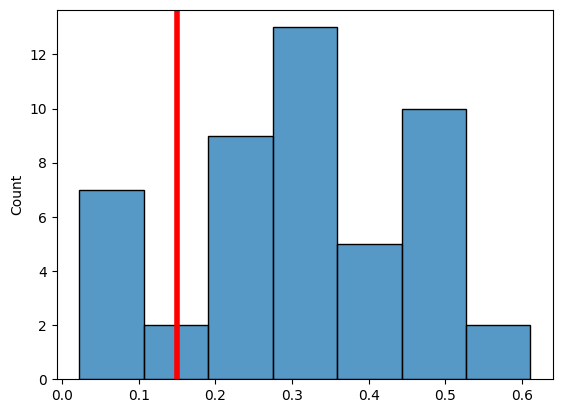

In [28]:
%matplotlib inline
# plot histogram of reprojected errors
sns.histplot([ edge['reprojected_err'].tolist() for edge in aux.values()])

# print the mean and std of the reprojected errors
print(np.mean([edge['reprojected_err'] for edge in aux.values()]))
print(np.std([edge['reprojected_err'] for edge in aux.values()]))

plt.axvline(x=0.15, linewidth=4, color='r')

plt.show()


# Detect markers & estimate camera-marker poses

In [14]:
if not LOAD:
    # This will compute camera-marker edges via PnP, in parallel
    cam_marker_edges = estimate_pose_mp(cams=dataset.im_data['cam'],
                                        im_filenames=dataset.im_data['filename'],
                                        #target_dict=aruco_obj,
                                        #flags='SOLVEPNP_IPPE_SQUARE',
                                        target_dict=charuco_dict,
                                        flags='SOLVEPNP_IPPE',
                                        brightness=0,
                                        contrast=0)
    
    # Save it to use later, if necessary
    pickle.dump(cam_marker_edges, open(os.path.join(DATASET_PATH, 'cam_marker_edges.pkl'), 'wb'))
    print("Saved")
else:
    cam_marker_edges = pickle.load( open(os.path.join(DATASET_PATH, 'cam_marker_edges.pkl'), 'rb') )
    print("Loaded")


Marker detection
Received 8000 images.
Started pool of 8 workers.
Merging dictionaries...
Found markers in 8000 images
Finished: 3314 markers detected.
Saved


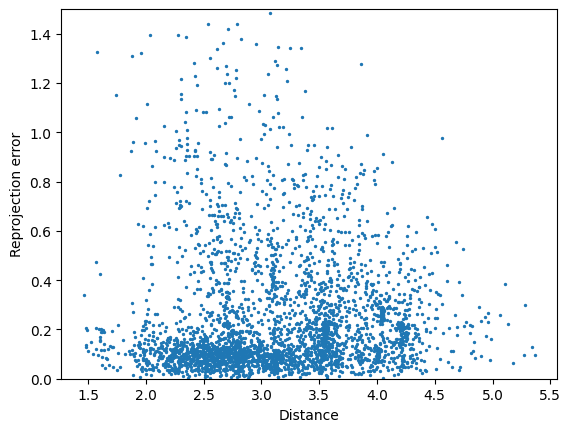

In [17]:
%matplotlib inline
plt.clf()

data = [[edge["distance"], edge["reprojected_err"]] for edge in cam_marker_edges.values()]
data = np.array(data)

plt.scatter(data[:,0], data[:,1], s=2)
plt.xlabel("Distance")
plt.ylabel("Reprojection error")
plt.ylim(0, 1.5)
plt.show()

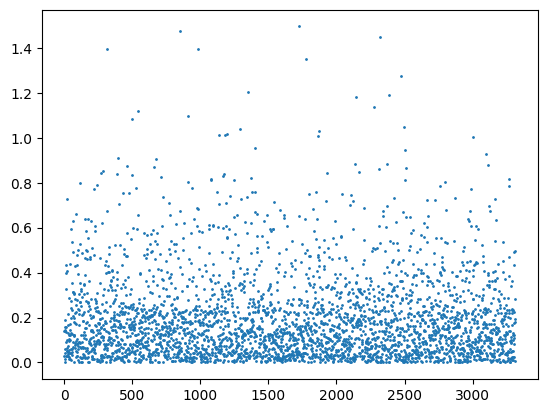

In [18]:
plt.figure()
data = np.array(  [ [edge["other_error"], edge["reprojected_err"]] for edge in cam_marker_edges.values() ] )

plt.plot( data[:,0]  - data[:,1], ".", markersize=2)
plt.show()

# cam_marker errors

1.5976512062970878 0.5113807078411341


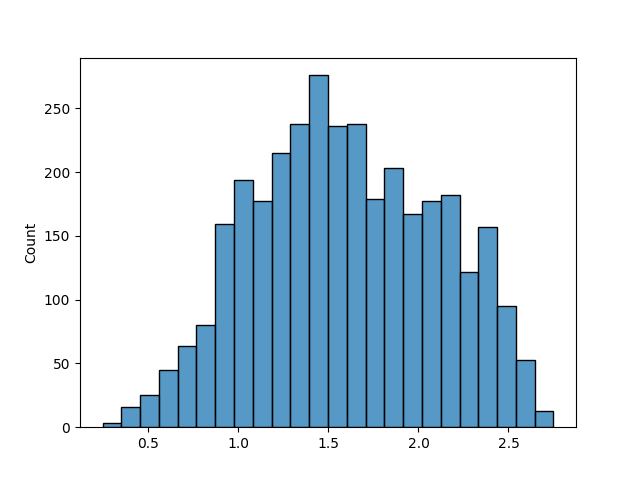

In [22]:
%matplotlib widget
plt.clf()
sns.histplot([edge['fro'].tolist() for edge in cam_marker_edges.values()])

# print the mean and std of the reprojected errors
print(np.mean([edge['fro'] for edge in cam_marker_edges.values()]),
      np.std([edge['fro'] for edge in cam_marker_edges.values()]))

plt.show()

# Optimization

In [21]:
pose_est = bipartite_se3sync(cam_marker_edges,
                            constraints=obj_pose_est,
                            noise_model_r=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1.0,
                            noise_model_t=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1.0,
                            #edge_filter=lambda edge : edge['reprojected_err'] < 1.0,
                            #edge_filter=lambda edge : edge['distance'] < 5.0,
                            edge_filter=lambda edge : np.abs (edge["other_error"] - edge["reprojected_err"] ) > 0.35,
                            maxiter=4,
                            lsqr_solver="conjugate_gradient",
                            dtype=np.float32)

Received graph with 2105 nodes 3314 edges
Applying constraints (0.048s).
Bipartite graph: 10 cameras, 368 timesteps, 468 edges.
Building 10x368 adjacency and 30x1104 SO(3) sparse matrices (0.005s).
Building power graph (0.002s).


Optimizing:   0%|    | 0/4 [00:00<?, ?it/s]

Building sparse 1494x1134 incidence matrix (0.080s).
Solving sparse linear system (0.014s).
Done!


# Cameras D Plot

In [68]:
def plot_frame(ax, H, label, scale=0.05):
    origin = H[:3, 3]
    x_axis = H[:3, 0]
    y_axis = H[:3, 1]
    z_axis = H[:3, 2]

    ax.quiver(*origin, *x_axis, color='r', length=scale, normalize=True)
    ax.quiver(*origin, *y_axis, color='g', length=scale, normalize=True)
    ax.quiver(*origin, *z_axis, color='b', length=scale, normalize=True)
    ax.text(*origin, label, fontsize=12, color='k')

[]

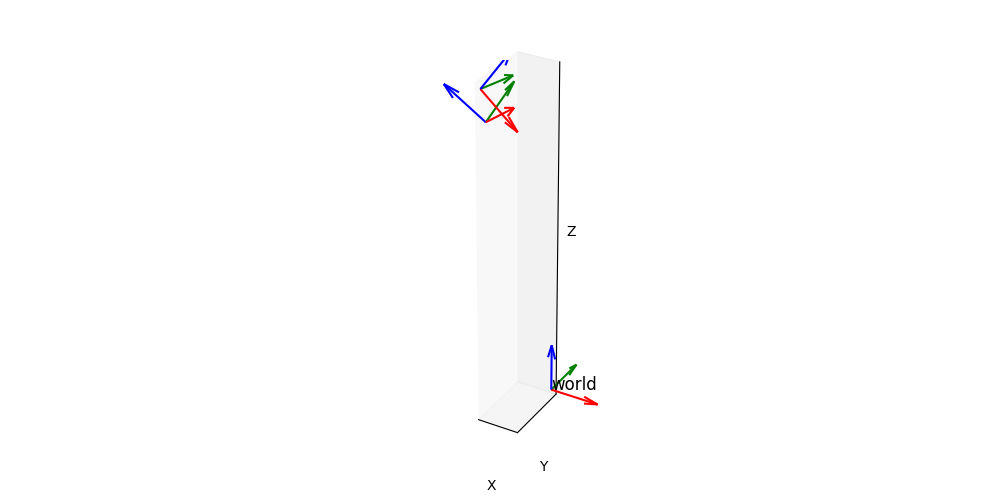

In [8]:
%matplotlib widget

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection='3d')




sol1 = np.vstack(([ 0.81612479 , 0.07583202 , 0.57287855, -0.36728851],
                [-0.13537795 , 0.98885446 , 0.0619651 , -0.64253869],
                [-0.56179457 ,-0.12812638 , 0.81729462 , 3.34425834],
                [ 0.     ,     0.     ,     0.   ,       1.        ]), dtype=np.float32)

sol2 = np.vstack([[ 0.74647196,  0.04290564, -0.66403216, -0.34588774],
                [-0.30633943 , 0.90803731, -0.28569984 ,-0.5926775 ],
                [ 0.59070785,  0.41668615,  0.69096808  ,3.01058371],
                [ 0.       ,   0.    ,      0.   ,       1.  ,      ]], dtype=np.float32)


origin = np.eye(4)
scale = 0.5
plot_frame(ax, origin, "world", scale)
plot_frame(ax, sol1, "", scale)
plot_frame(ax, sol2, "", scale)

#draw a plane in XY Plane

ax.set_aspect('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


# remove labels xticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])


(4, 20)

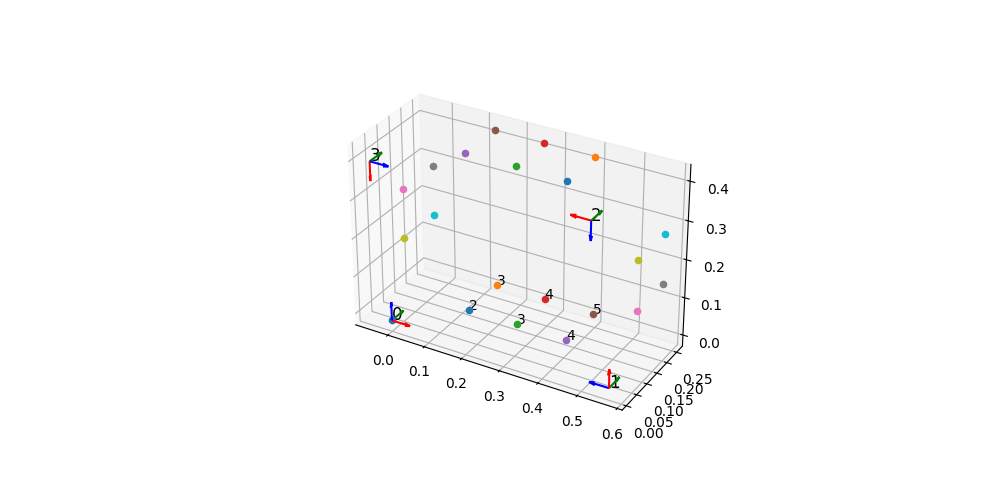

In [61]:

#%matplotlib inline
%matplotlib widget

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection='3d')

is_charuco = True

wrl_id = "0"
pts_wrld = []
for marker_id, pose in obj_pose_est.items():
    
    if ("_" in marker_id):
        continue
    
    plot_frame(ax, obj_pose_est[wrl_id].inv().pose() @ obj_pose_est[marker_id].pose()  , marker_id) 
    
    #draw the chessbaord corners in space for each charuco board
    if is_charuco:
        for i in range(1,charuco_dict[marker_id]["sizeX"]):
            for j in range(1, charuco_dict[marker_id]["sizeY"]):
                
                if marker_id == "0":
                    ax.scatter( i * charuco_dict[marker_id]["squareLength"], j * charuco_dict[marker_id]["squareLength"], 0)
                    pts_wrld.append([i*charuco_dict[marker_id]["squareLength"], j*charuco_dict[marker_id]["squareLength"], 0])
                    
                    ax.text(i*charuco_dict[marker_id]["squareLength"], j*charuco_dict[marker_id]["squareLength"], 0, f"{ j * (charuco_dict[marker_id]['sizeY'] - 2) + i }")
                    
                else:
                    #continue
                    # transform the points to the "0" frame
                    point = obj_pose_est[wrl_id].inv()._pose @ obj_pose_est[marker_id]._pose @  np.array([i*charuco_dict[marker_id]["squareLength"], j*charuco_dict[marker_id]["squareLength"], 0, 1])
                    ax.scatter(point[0], point[1], point[2])
                    pts_wrld.append(point[:3])
                    
    else:
        
        marker_in_wrld = obj_pose_est[wrl_id].inv().pose() @ obj_pose_est[marker_id].pose()
        pts_wrld.append(marker_in_wrld[:3, 3])
            
                    
                

# draw the rest of the cube
ax.scatter(0,0,0)
# aspect ratio of the plot to be equal
ax.set_aspect('equal')

#ax.view_init(elev=0, azim=90, roll=0)

# show the plot
#plt.show()


# object in marker 0 frame in homogenous coordinates
pts_wrld = np.array(pts_wrld)
pts_wrld = np.vstack( [pts_wrld.T, np.ones(pts_wrld.shape[0]) ] )
pts_wrld.shape

#pts_wrld = np.array([[ 0, 0,0, 1]]).T
#pts_wrld.shape

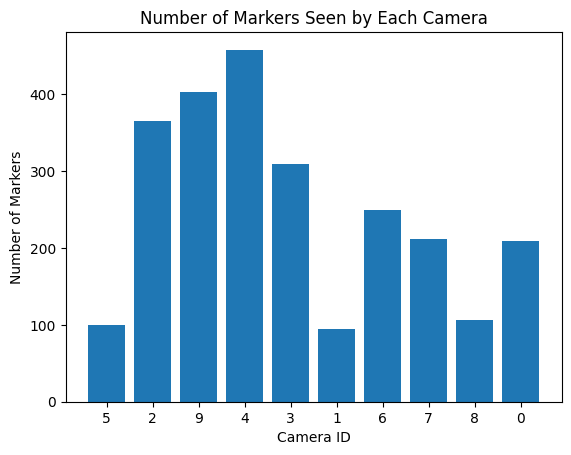

In [63]:
%matplotlib inline

import matplotlib.pyplot as plt

# Count the number of markers for each camera
marker_counts = {}
for cam_id, _ in cam_marker_edges.items():

    cam_id = cam_id[0]  # Extract the camera ID
    
    if cam_id in marker_counts:
        marker_counts[cam_id] += 1
    else:
        marker_counts[cam_id] = 1

# Create the histogram
plt.figure()
plt.bar(marker_counts.keys(), marker_counts.values())
plt.xlabel('Camera ID')
plt.ylabel('Number of Markers')
plt.title('Number of Markers Seen by Each Camera')
plt.show()

# Plot cameras in 3D Space

In [66]:
from src.vican.vican.geometry import SE3, rotz
from src.vican.vican.plot import plot_cams_3D

for cam_id, cam in dataset.cams.items():
    
    cam.extrinsics = pose_est[cam_id] 

pos_obj = [pose.t().tolist() for cam_id, pose in pose_est.items() if "_" in cam_id] 



pos_obj = np.array(pos_obj)

plot_cams_3D(dataset.cams.values(), pos_obj)

Saving to output.html


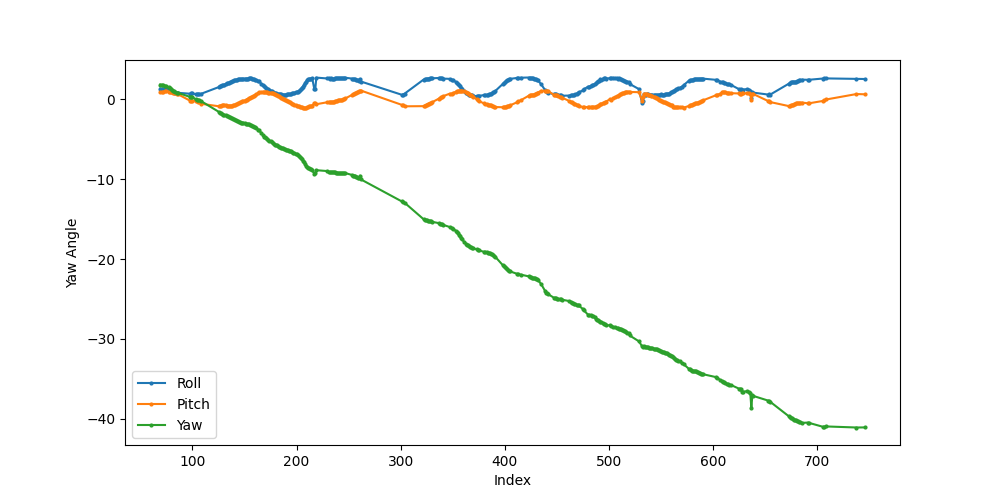

In [23]:
%matplotlib widget
from scipy.spatial.transform import Rotation

plt.figure(figsize=(10,5))  


angles = []
#position = dict()

for tuple_id, pose in pose_est.items():
    
    if "_" in tuple_id:
        #print(tuple_id.split("_")[1])
        #print(pose)
        
        rot_mat = pose.R()
        angles.append(np.hstack((Rotation.from_matrix(rot_mat).as_euler('xyz'), int(tuple_id.split("_")[0]) ) ) )
        

angles = np.array(angles)
angles = angles[angles[:, -1].argsort()] # sort by time
angles[:, :3] = np.unwrap(angles[:, :3], axis=0)

plt.plot(angles[:,-1], angles[:,0],"-o", label='Roll', markersize=2)
plt.plot(angles[:,-1], angles[:,1],"-o", label='Pitch', markersize=2)
plt.plot(angles[:,-1], angles[:,2],"-o", label='Yaw', markersize=2)
plt.xlabel('Index')
plt.ylabel('Yaw Angle')
#plt.title('Yaw Angle over Index')
plt.legend()
#plt.xlim(310,350)
plt.show()


# Marker projected in image space after optimization

## Charuco list

In [69]:
charuco_list = []
for i in range(0,charuco_dict["num_boards"] + 1):
        
    charuco_board = cv.aruco.CharucoBoard(
        size=(charuco_dict[str(i)]["sizeX"], charuco_dict[str(i)]["sizeY"]),
        squareLength=charuco_dict[str(i)]["squareLength"],
        markerLength=charuco_dict[str(i)]["markerLength"],
        dictionary= cv.aruco.getPredefinedDictionary(charuco_dict[str(i)]["dictionary"]),
        ids=charuco_dict[str(i)]["ids"])
    
    charuco_board.setLegacyPattern(True)
    charuco_list.append(charuco_board)      
    
    
charuco_list[0]

< cv2.aruco.CharucoBoard 0x7efe14ac4b90>

## Projection

In [70]:
%matplotlib inline
import os
from tqdm import tqdm

for i in tqdm(range(0, len(dataset.im_data["filename"])), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
    
    timestep = dataset.im_data["timestamp"][i]
    cam_id = dataset.im_data["cam_id"][i]
    
    try:
        #xyz_0 into wrld frame
        xyz_wrl = pose_est[f"{timestep}_0"]._pose @ pts_wrld
    except:
        #print("timestep not found")
        continue
    
    # k [ R^T | -R^T*t] = P
    if 0: 
        # its better to use the opencv projectpoinrs since it uses the distortion model
        cam_model = np.array( dataset.im_data["cam"][i].intrinsics
                            @ 
                            np.concatenate( ( pose_est[cam_id].R().T , -1 * pose_est[cam_id].R().T @ np.array([pose_est[cam_id].t()]).T ) , axis=1) )   # in camera frame

        # 3d points in marker0 frame into frame camera
        uv_0 = cam_model @ xyz_wrl

        # normalize homogenous coordinates
        uv_0 = uv_0[:2,:]/ uv_0[2,:]
    else:
        # pose est brings from camera to wrld frame
        uv_0 = cv.projectPoints(objectPoints=xyz_wrl[:3 , :], rvec=cv.Rodrigues(pose_est[cam_id].R().T)[0], tvec=-1*pose_est[cam_id].R().T @ pose_est[cam_id].t(),
                                cameraMatrix=dataset.cams[cam_id].intrinsics, distCoeffs=dataset.cams[cam_id].distortion)[0].squeeze().T
        
    im = cv.imread(dataset.im_data["filename"][i])
    
    # draw charuco detections
    if is_charuco:
        for board in charuco_list:
            
            corners, ids, rejected = cv.aruco.detectMarkers(im, board.getDictionary())
            if len(corners) > 0:
                retval, charuco_corners, charuco_ids = cv.aruco.interpolateCornersCharuco(corners, ids, im, board)
                if retval:
                    for z in charuco_corners:
                        z =  z.squeeze()
                        im = cv.circle(im, (int(z[0]), int(z[1])), 1, (0, 0, 255), 1)
    
    # draw the reprojected points from a known object structure
    try:
        for j in range(uv_0.shape[1]):
            im = cv.circle(im, (int(uv_0[0,j]), int(uv_0[1,j])), 1, (0,255,0), 1)
    except:# just one pt
        im = cv.circle(im, (int(uv_0[0]), int(uv_0[1])), 1, (0,255,0), 1)
        
    cube_in_cam_frame = pose_est[timestep + "_0"].inv() @ pose_est[cam_id]
    cube_in_cam_frame = cube_in_cam_frame.inv()
    
    im = cv.drawFrameAxes(im, dataset.cams[cam_id].intrinsics, dataset.cams[cam_id].distortion,
                          cv.Rodrigues(cube_in_cam_frame.R())[0], cube_in_cam_frame.t(), 0.1)
            
    
    # Create folder if it doesn't exist
    folder_path = f"test_images/{cam_id}"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
    cv.imwrite(f"test_images/{cam_id}/{timestep}.png", im)

plt.figure(figsize=(12,12))
plt.imshow(im) 
plt.show()

 31%|███       | 2451/8000 [01:06<02:31, 36.59it/s]         


KeyboardInterrupt: 

# projection with pre-computed edges

In [ ]:
def get_image_idx(cam_id, time):
    
    idx = None
    for i in range(0, len(dataset.im_data["filename"])):
        if dataset.im_data["cam_id"][i] == cam_id and dataset.im_data["timestamp"][i] == time:
            idx = i
            
    return idx

In [ ]:
%matplotlib inline

from src.vican.vican.geometry import SE3

plt.figure(figsize=(12,12))
resX = dataset.im_data["cam"][0].resolution_x 
resY = dataset.im_data["cam"][0].resolution_y

for identifier,edge in cam_marker_edges.items():
    
    mosaic = np.zeros( (resX, resY * len(dataset.cams), 3), dtype=np.uint8)
    
    #skip a random number of items in the dictionary
    #if np.random.rand() > 0.01:
    #    continue
    
    cam_id = identifier[0]
    timestep = identifier[1].split('_')[0]
    marker_id = identifier[1].split('_')[1]
    
    
    
    
    #if marker_id != "0":
    #    continue
    
    #if timestep != "144":
    #    continue
    
    
    # find image index in dataset
    im_idx = get_image_idx(cam_id, timestep)
    if im_idx == None:
        continue
    
    # find the ids of other cameras
    other_cam_ids = [k for k in dataset.cams.keys() if k != cam_id]
    
    # find the image index of the other cameras
    other_imgs_idx = [get_image_idx(k, timestep) for k in other_cam_ids]
    
    im = cv.imread(dataset.im_data["filename"][im_idx])
    
    # represent the object pts in the detected marker frame - "0" frame is the root object frame
    pts_detect_frame = obj_pose_est[marker_id].inv().pose() @ obj_pose_est["0"].pose() @ pts_wrld
    #pts_detect_frame = pts_detect_frame[:3,:] / pts_detect_frame[3,:] # normalize homogenous coordinates
    

    uv_marker = cv.projectPoints(pts_detect_frame[:3, :] / pts_detect_frame[3,:],
                                 edge['pose'].R(),
                                 edge['pose'].t(),
                                 dataset.im_data["cam"][im_idx].intrinsics,
                                 dataset.im_data["cam"][im_idx].distortion)[0].squeeze()
    
    
    #go through all other cameras and draw the reprojected points
    for idx in other_imgs_idx:
        
        new_im = cv.imread(dataset.im_data["filename"][idx])
        
        # change referencial to other camera 
        tf_new_cam =SE3 ( pose = pose_est[dataset.im_data["cam_id"][idx]].inv().pose() @ pose_est[cam_id].pose() @ edge["pose"].pose() )
        
        
        markers_other_cam = cv.projectPoints(pts_detect_frame[:3, :] / pts_detect_frame[3,:],
                                            tf_new_cam.R().astype(np.float64),
                                            tf_new_cam.t().astype(np.float64),
                                            dataset.im_data["cam"][idx].intrinsics,
                                            dataset.im_data["cam"][idx].distortion)[0].squeeze()
        
        
        for i in range(markers_other_cam.shape[0]):
            new_im = cv.circle(new_im, (int(markers_other_cam[i,0]), int(markers_other_cam[i,1])), 2, (0,255,0), 2)
            
        # append new_im to im
        mosaic[:resX ,int( dataset.im_data["cam_id"][idx] ) * resY : int( dataset.im_data["cam_id"][idx]) * resY + resY, :] = new_im
        
    
    #im = cv.drawFrameAxes(im, cameraMatrix=dataset.im_data["cam"][im_idx].intrinsics,
    #                      distCoeffs=dataset.im_data["cam"][im_idx].distortion,
    #                      rvec=edge['pose'].R(),
    #                      tvec=edge['pose'].t(),
    #                      length=0.12)
    
    for i in range(uv_marker.shape[0]):
        im = cv.circle(im, (int(uv_marker[i,0]), int(uv_marker[i,1])), 2, (0,0,255), 2)
    
    mosaic[:resX , int(cam_id) * resY : int(cam_id) * resY + resY, :] = im
    
    cv.imwrite(f"test_images/mosaic_{timestep}_{cam_id}_{marker_id}.png", mosaic)
       

    

KeyboardInterrupt: 

<Figure size 1200x1200 with 0 Axes>

In [ ]:
resX = dataset.im_data["cam"][0].resolution_x * len(dataset.cams)
resX


3072

In [ ]:
position_list = []
for cam_id, pose in pose_est.items():
    if "_" in cam_id:
        continue
    position_list.append(pose_est[cam_id].t())
    print(np.linalg.det(pose_est[cam_id].R()))


print(position_list)


print(np.linalg.norm(position_list[0]- position_list[1]))
print(np.linalg.norm(position_list[1]- position_list[2]))
print(np.linalg.norm(position_list[2]- position_list[3]))
print(np.linalg.norm(position_list[2]- position_list[0]))

#print(cam_id)
#print(pose)
    

In [ ]:
obj_pose_est["0"]

[[ 1.      0.      0.     -0.1501]
 [-0.      1.      0.     -0.0695]
 [-0.     -0.      1.     -0.1543]
 [ 0.      0.      0.      1.    ]]